In [25]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import zipfile
import os
import shutil
import random
warnings.filterwarnings("ignore")

In [26]:
zip_path = './BrainTumor-dataset.zip'
extract_path = './BrainTumor_Dataset/'

with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_path)

print("Folders inside brain_tumor_Dataset:", os.listdir(extract_path))

Folders inside brain_tumor_Dataset: ['glioma', 'notumor', 'pituitary', 'meningioma']


In [27]:
original_dataset_dir = './BrainTumor_Dataset'
output_base_dir = './BrainTumor_Dataset_Split'

train_dir = os.path.join(output_base_dir, 'train')
test_dir = os.path.join(output_base_dir, 'test')

# Define split ratio
test_ratio = 0.2  # 20% for test, 80% for train

# Make sure output directories exist
os.makedirs(train_dir, exist_ok=True)
os.makedirs(test_dir, exist_ok=True)

# Process each class folder (glioma, meningioma, notumor, pituitary)
for class_name in os.listdir(original_dataset_dir):
    class_path = os.path.join(original_dataset_dir, class_name)
    if not os.path.isdir(class_path):
        continue

    # Collect all image filenames for this class
    all_images = os.listdir(class_path)
    random.shuffle(all_images)

    # Split images into train and test
    split_index = int(len(all_images) * (1 - test_ratio))
    train_images = all_images[:split_index]
    test_images = all_images[split_index:]

    # Create class folders in train and test
    os.makedirs(os.path.join(train_dir, class_name), exist_ok=True)
    os.makedirs(os.path.join(test_dir, class_name), exist_ok=True)

    # Copy images to train and test folders
    for img in train_images:
        src = os.path.join(class_path, img)
        dst = os.path.join(train_dir, class_name, img)
        shutil.copyfile(src, dst)

    for img in test_images:
        src = os.path.join(class_path, img)
        dst = os.path.join(test_dir, class_name, img)
        shutil.copyfile(src, dst)

    print(f"Class {class_name}: {len(train_images)} train images, {len(test_images)} test images")

Class glioma: 240 train images, 60 test images
Class notumor: 324 train images, 81 test images
Class pituitary: 240 train images, 60 test images
Class meningioma: 244 train images, 62 test images


# Displaying Images

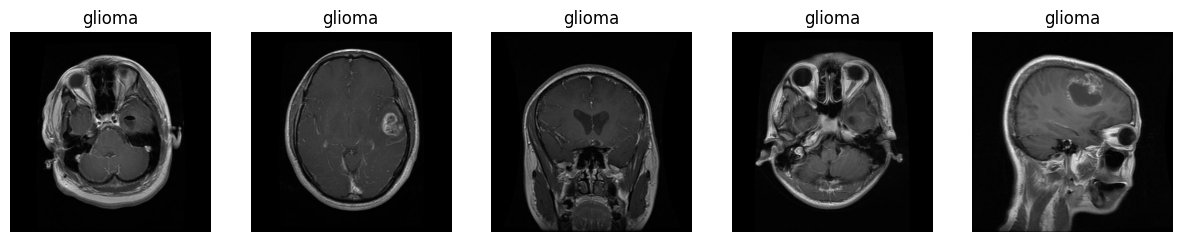

In [28]:
from tensorflow.keras.preprocessing import image
# Get class names (folder names)
class_names = os.listdir(extract_path)

# Select a random class
selected_class = np.random.choice(class_names)

# List images in that class  -- This is where the change is made
class_path = os.path.join(extract_path, selected_class)
image_files = os.listdir(class_path) # Now it lists files in the selected class folder

# Show a few images
fig, axes = plt.subplots(1, 5, figsize=(15, 5))
for i, img_name in enumerate(image_files[:5]):  # Show first 5 images
    img_path = os.path.join(class_path, img_name)
    img = image.load_img(img_path)  # Load image
    axes[i].imshow(img)
    axes[i].axis("off")
    axes[i].set_title(selected_class)  # Show class name

plt.show()

# 🧰 Data Preprocessing

In [29]:
from tensorflow.keras.preprocessing import image

for img_name in os.listdir(extract_path):
    # Load the grayscale image
    img_path = os.path.join(extract_path, img_name)

if os.path.isfile(img_path):

    img = image.load_img(img_path, color_mode='grayscale', target_size=(128, 128))  # load as grayscale
    img_array = image.img_to_array(img)  # Convert image to numpy array (height, width, 1)

    # Convert grayscale to RGB
    img_rgb = tf.image.grayscale_to_rgb(img_array)  # Convert to (height, width, 3)

    # Save the converted image
    img_rgb = np.array(img_rgb, dtype=np.uint8)  # Convert back to uint8 for saving
    save_path = os.path.join(extract_path, img_name)
    image.save_img(save_path, img_rgb)

In [30]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Data Augmentation for Training Data
train_datagen = ImageDataGenerator(
    rescale=1./255,              # Normalize pixel values between 0 and 1
    rotation_range=30,           # Random rotations between -30 to 30 degrees
    width_shift_range=0.2,       # Random horizontal shift by 20%
    height_shift_range=0.2,      # Random vertical shift by 20%
    shear_range=0.2,             # Random shear transformations
    zoom_range=0.2,              # Random zoom range
    horizontal_flip=True,        # Random horizontal flip
    vertical_flip=True,          # Random vertical flip
    fill_mode='nearest',         # Filling missing pixels after transformations
    validation_split=0.2         # Split data into training and validation sets
)

valid_datagen = ImageDataGenerator(
    rescale=1./255,               # Normalize validation images
    validation_split=0.2          # Use validation split
)

test_datagen = ImageDataGenerator(
    rescale=1./255                # Normalize test data
)

train_data = train_datagen.flow_from_directory(
    './BrainTumor_Dataset_Split/train/',
    target_size=(128, 128),
    class_mode='sparse',
    color_mode='rgb',
    batch_size=32,
    subset='training'
)

valid_data = train_datagen.flow_from_directory(
    './BrainTumor_Dataset_Split/train/',
    target_size=(128, 128),
    class_mode='sparse',
    color_mode='rgb',
    batch_size=32,
    subset='validation'
)

test_data = test_datagen.flow_from_directory(
    './BrainTumor_Dataset_Split/test/',  # From a different folder!
    target_size=(128, 128),
    class_mode='sparse',
    color_mode='rgb',
    batch_size=32
)

Found 1003 images belonging to 4 classes.
Found 249 images belonging to 4 classes.
Found 467 images belonging to 4 classes.


# Building CNN model :

**Feature extration**

In [31]:
from tensorflow.keras import layers, models
from tensorflow.keras.layers import Dropout # Import Dropout

model = models.Sequential()

# Add Convolutional layers, followed by pooling layers, and dense layers
model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(128, 128, 3)))  # First Conv Layer
model.add(layers.MaxPooling2D((2, 2)))  # Max Pooling
model.add(Dropout(0.25))

model.add(layers.Conv2D(64, (3, 3), activation='relu'))  # Second Conv Layer
model.add(layers.MaxPooling2D((2, 2)))  # Max Pooling
model.add(Dropout(0.25))

model.add(layers.Conv2D(128, (3, 3), activation='relu'))  # Third Conv Layer
model.add(layers.MaxPooling2D((2, 2)))  # Max Pooling
model.add(Dropout(0.25))


**Fully connected Layers**

In [32]:
# Flatten the output to feed into fully connected layers
model.add(layers.Flatten())

**Classification**

In [33]:
from tensorflow.keras import layers, models
from tensorflow.keras.layers import Dropout, Dense, BatchNormalization
from tensorflow.keras.regularizers import l1_l2
# Add Dense layers
model.add(Dense(128, activation='relu', kernel_regularizer=l1_l2(l1=0.01, l2=0.01)))
model.add(BatchNormalization())

model.add(layers.Dense(4, activation='softmax'))  # 4 output classes (softmax for multi-class)

In [34]:
# Compile the model
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',  # Use categorical loss function for multi-class
              metrics=['accuracy'])

# Print model summary
model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_3 (Conv2D)                    │ (None, 126, 126, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_3 (MaxPooling2D)       │ (None, 63, 63, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_4 (Dropout)                  │ (None, 63, 63, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_4 (Conv2D)                    │ (None, 61, 61, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_4 (MaxPooling2D)       │ (None, 30, 30, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_5 (Dropout)                  │ (None, 30, 30, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_5 (Conv2D)                    │ (None, 28, 28, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_5 (MaxPooling2D)       │ (None, 14, 14, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_6 (Dropout)                  │ (None, 14, 14, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_2 (Flatten)                  │ (None, 25088)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 128)                 │       3,211,392 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 128)                 │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_5 (Dense)                      │ (None, 4)                   │             516 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 3,305,668 (12.61 MB)

 Trainable params: 3,305,412 (12.61 MB)

 Non-trainable params: 256 (1.00 KB)

# Training the Model

In [35]:
from tensorflow.keras.callbacks import EarlyStopping

# Train the model using the data from the generators

early_stop = EarlyStopping(monitor='val_loss',  # Monitor validation loss
                           patience=3,
                           restore_best_weights=True)
history = model.fit(
    train_data,
    epochs=15,    # You can change the number of epochs as needed
    validation_data=valid_data,
    callbacks=[early_stop]
)

Epoch 1/15
32/32 ━━━━━━━━━━━━━━━━━━━━ 18s 377ms/step - accuracy: 0.4753 - loss: 135.3717 - val_accuracy: 0.2329 - val_loss: 20.8689
Epoch 2/15
32/32 ━━━━━━━━━━━━━━━━━━━━ 7s 224ms/step - accuracy: 0.4878 - loss: 15.8737 - val_accuracy: 0.2289 - val_loss: 8.6584
Epoch 3/15
32/32 ━━━━━━━━━━━━━━━━━━━━ 6s 194ms/step - accuracy: 0.5232 - loss: 7.4800 - val_accuracy: 0.2329 - val_loss: 6.4372
Epoch 4/15
32/32 ━━━━━━━━━━━━━━━━━━━━ 7s 223ms/step - accuracy: 0.5298 - loss: 6.0262 - val_accuracy: 0.2530 - val_loss: 6.3328
Epoch 5/15
32/32 ━━━━━━━━━━━━━━━━━━━━ 8s 237ms/step - accuracy: 0.5778 - loss: 5.8383 - val_accuracy: 0.2289 - val_loss: 6.2978
Epoch 6/15
32/32 ━━━━━━━━━━━━━━━━━━━━ 6s 194ms/step - accuracy: 0.5944 - loss: 5.7174 - val_accuracy: 0.2410 - val_loss: 5.8931
Epoch 7/15
32/32 ━━━━━━━━━━━━━━━━━━━━ 7s 223ms/step - accuracy: 0.5812 - loss: 5.4980 - val_accuracy: 0.2570 - val_loss: 5.8681
Epoch 8/15
32/32 ━━━━━━━━━━━━━━━━━━━━ 6s 192ms/step - accuracy: 0.5926 - loss: 5.4242 - val_accurac

# Model Evaluation

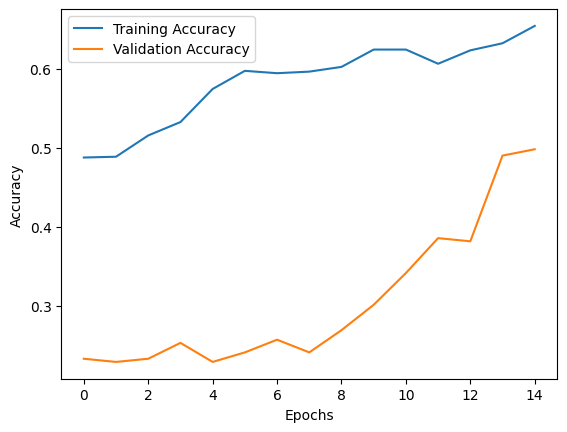

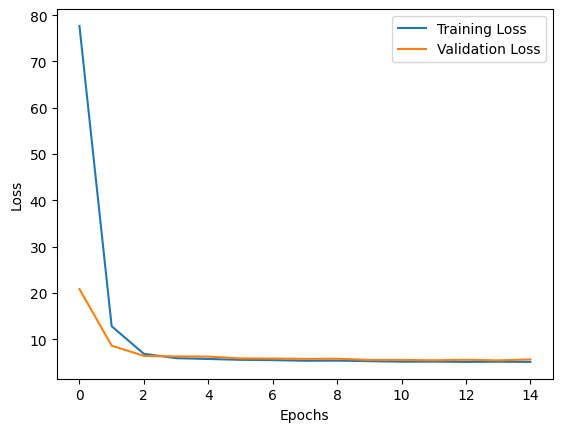

In [36]:
# Plot the training accuracy and validation accuracy
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Plot the training loss and validation loss
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [37]:
# true_labels = []
# predicted_labels = []

# # Make sure your test_data uses `shuffle=False` so order is fixed.
# for images, labels in test_data:
#     preds = model.predict(images)
#     predicted_labels.extend(np.argmax(preds, axis=1))
#     true_labels.extend(labels)

# true_labels = np.array(true_labels).astype(int)
# predicted_labels = np.array(predicted_labels)

**Classification Report**

In [38]:
# from sklearn.metrics import classification_report, confusion_matrix

# # Class names (same order as your `flow_from_directory`)
# class_names = list(train_data.class_indices.keys())

# # Generate the report
# print(classification_report(true_labels, predicted_labels, target_names=class_names))

**Confusion Matrix**

In [39]:
# import matplotlib.pyplot as plt
# import seaborn as sns

# cm = confusion_matrix(true_labels, predicted_labels)

# plt.figure(figsize=(8,6))
# sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
# plt.xlabel('Predicted Label')
# plt.ylabel('True Label')
# plt.title('Confusion Matrix')
# plt.show()

# Pretrained VGG16 model

In [43]:
from tensorflow.keras.applications import VGG16
from tensorflow.keras.applications.vgg16 import preprocess_input

img_size = 128
channel=3

#preprocessing for VGG16
train_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input,
    rotation_range=30,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    vertical_flip=True
)

valid_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input
)

test_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input
)

# Load the VGG16 model
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(img_size, img_size, channel))

# Freeze the layers of the base model
for layer in base_model.layers:
    layer.trainable = False

In [44]:
from tensorflow.keras.layers import Flatten, Dense, Dropout # Import Flatten
from tensorflow.keras.models import Model
# Create a custom model on top of the pretrained VGG16 model
x = Flatten()(base_model.output)
x = Dense(512, activation='relu')(x)
x = Dropout(0.5)(x)
predictions = Dense(10, activation='softmax')(x)
Pre_model = Model(inputs=base_model.input, outputs=predictions)

In [45]:
from tensorflow.keras.optimizers import Adam

# Compile the model with Adam optimizer, categorical crossentropy loss, and accuracy metric
Pre_model.compile(optimizer=Adam(learning_rate=0.0001), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

Pre_model.summary()

Model: "functional_27"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_4 (InputLayer)           │ (None, 128, 128, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv1 (Conv2D)                │ (None, 128, 128, 64)        │           1,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv2 (Conv2D)                │ (None, 128, 128, 64)        │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_pool (MaxPooling2D)           │ (None, 64, 64, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv1 (Conv2D)                │ (None, 64, 64, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv2 (Conv2D)                │ (None, 64, 64, 128)         │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_pool (MaxPooling2D)           │ (None, 32, 32, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv1 (Conv2D)                │ (None, 32, 32, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv2 (Conv2D)                │ (None, 32, 32, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv3 (Conv2D)                │ (None, 32, 32, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_pool (MaxPooling2D)           │ (None, 16, 16, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv1 (Conv2D)                │ (None, 16, 16, 512)         │       1,180,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv2 (Conv2D)                │ (None, 16, 16, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv3 (Conv2D)                │ (None, 16, 16, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_pool (MaxPooling2D)           │ (None, 8, 8, 512)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv1 (Conv2D)                │ (None, 8, 8, 512)           │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv2 (Conv2D)                │ (None, 8, 8, 512)           │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv3 (Conv2D)                │ (None, 8, 8, 512)           │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_pool (MaxPooling2D)           │ (None, 4, 4, 512)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_3 (Flatten)                  │ (None, 8192)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_6 (Dense)                      │ (None, 512)                 │       4,194,816 │
├──────────────────────────────────────┼─────────────────────────────┼──────────────

 Total params: 18,914,634 (72.15 MB)

 Trainable params: 4,199,946 (16.02 MB)

 Non-trainable params: 14,714,688 (56.13 MB)

In [46]:
early_stop = EarlyStopping(monitor='val_loss', patience=3)

history = Pre_model.fit(
    train_data,
    epochs=15,
    validation_data=valid_data,
    callbacks=[early_stop]
)

Epoch 1/15
32/32 ━━━━━━━━━━━━━━━━━━━━ 20s 521ms/step - accuracy: 0.3075 - loss: 1.7276 - val_accuracy: 0.4538 - val_loss: 1.2669
Epoch 2/15
32/32 ━━━━━━━━━━━━━━━━━━━━ 8s 251ms/step - accuracy: 0.5473 - loss: 1.0598 - val_accuracy: 0.5060 - val_loss: 1.2031
Epoch 3/15
32/32 ━━━━━━━━━━━━━━━━━━━━ 8s 253ms/step - accuracy: 0.6746 - loss: 0.8245 - val_accuracy: 0.5382 - val_loss: 1.1114
Epoch 4/15
32/32 ━━━━━━━━━━━━━━━━━━━━ 8s 259ms/step - accuracy: 0.6753 - loss: 0.8083 - val_accuracy: 0.5462 - val_loss: 1.1628
Epoch 5/15
32/32 ━━━━━━━━━━━━━━━━━━━━ 10s 241ms/step - accuracy: 0.7163 - loss: 0.7313 - val_accuracy: 0.5743 - val_loss: 1.0641
Epoch 6/15
32/32 ━━━━━━━━━━━━━━━━━━━━ 7s 215ms/step - accuracy: 0.7174 - loss: 0.7217 - val_accuracy: 0.5622 - val_loss: 1.1202
Epoch 7/15
32/32 ━━━━━━━━━━━━━━━━━━━━ 9s 294ms/step - accuracy: 0.7334 - loss: 0.6875 - val_accuracy: 0.5783 - val_loss: 1.0438
Epoch 8/15
32/32 ━━━━━━━━━━━━━━━━━━━━ 8s 249ms/step - accuracy: 0.7341 - loss: 0.6502 - val_accuracy: 

# Model Finetuning

In [47]:
# Unfreeze the last 4 layers of the base model for fine-tuning
for layer in base_model.layers[-4:]:
    layer.trainable = True

# Compile the model with Adam optimizer, binary crossentropy loss, and accuracy metric
Pre_model.compile(optimizer=Adam(learning_rate=1e-5), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

early_stop = EarlyStopping(monitor='val_loss', patience=3)

# Continue training the model with fine-tuning
history_fine = Pre_model.fit(
    train_data,
    validation_data=valid_data,
    epochs=20,
    callbacks=[early_stop]
)

Epoch 1/20
32/32 ━━━━━━━━━━━━━━━━━━━━ 15s 356ms/step - accuracy: 0.7803 - loss: 0.5751 - val_accuracy: 0.6546 - val_loss: 0.9903
Epoch 2/20
32/32 ━━━━━━━━━━━━━━━━━━━━ 7s 221ms/step - accuracy: 0.7991 - loss: 0.5348 - val_accuracy: 0.6707 - val_loss: 0.9165
Epoch 3/20
32/32 ━━━━━━━━━━━━━━━━━━━━ 8s 246ms/step - accuracy: 0.8065 - loss: 0.4902 - val_accuracy: 0.6908 - val_loss: 0.8789
Epoch 4/20
32/32 ━━━━━━━━━━━━━━━━━━━━ 8s 248ms/step - accuracy: 0.8050 - loss: 0.5006 - val_accuracy: 0.6787 - val_loss: 0.8778
Epoch 5/20
32/32 ━━━━━━━━━━━━━━━━━━━━ 7s 218ms/step - accuracy: 0.8130 - loss: 0.5067 - val_accuracy: 0.6546 - val_loss: 0.9040
Epoch 6/20
32/32 ━━━━━━━━━━━━━━━━━━━━ 8s 247ms/step - accuracy: 0.8167 - loss: 0.4652 - val_accuracy: 0.7068 - val_loss: 0.8190
Epoch 7/20
32/32 ━━━━━━━━━━━━━━━━━━━━ 7s 217ms/step - accuracy: 0.8321 - loss: 0.4317 - val_accuracy: 0.7349 - val_loss: 0.7778
Epoch 8/20
32/32 ━━━━━━━━━━━━━━━━━━━━ 8s 240ms/step - accuracy: 0.8465 - loss: 0.4359 - val_accuracy: 0

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 525ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━

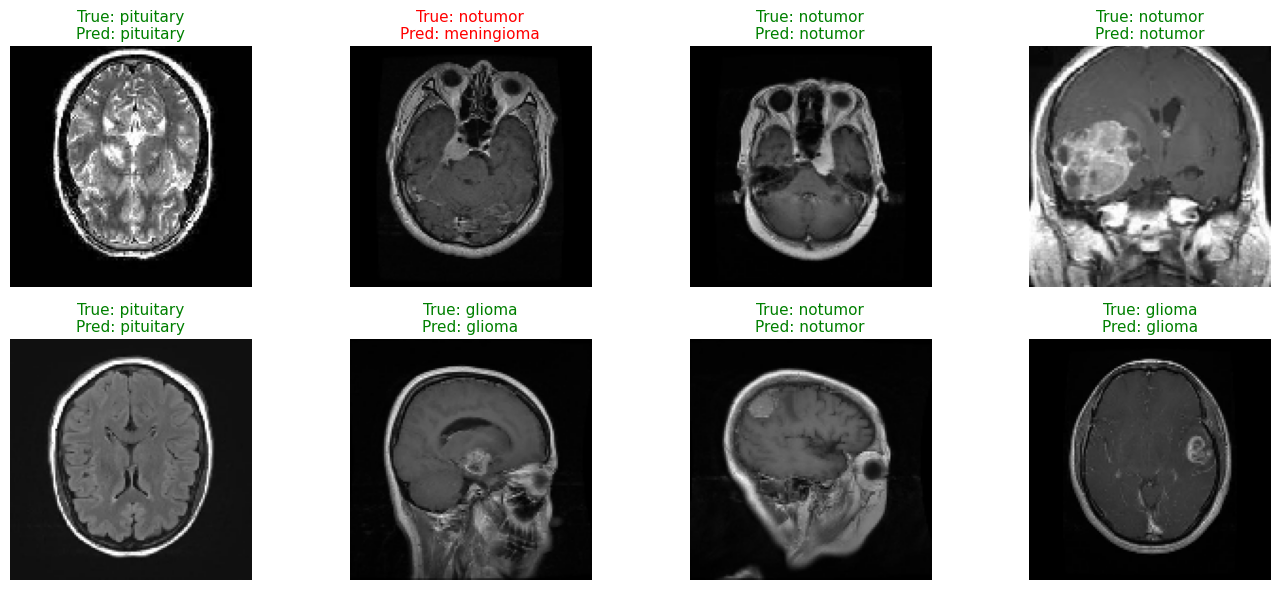

In [48]:
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np

# Define class names
class_names = ['glioma', 'notumor', 'pituitary', 'meningioma']

# Prepare figure
fig, axes = plt.subplots(2, 4, figsize=(14, 6))

# Get first batch of test data
test_iter = iter(test_data)

for x in range(8):
    image_batch, label_batch = next(test_iter)

    # Loop through images in batch
    for i in range(len(image_batch)):
        ax = axes.flat[x]  # Each subplot axis
        image = image_batch[i]
        label = label_batch[i]

        # Prediction
        prediction = Pre_model.predict(tf.expand_dims(image, axis=0))
        predicted_label = np.argmax(prediction)

        # Get class names
        predicted_class_name = class_names[predicted_label]
        true_class_name = class_names[int(label)]

        # Show image
        ax.imshow(image)
        ax.axis('off')

        # Set title with true and predicted labels
        if predicted_class_name == true_class_name:
            color = 'green'
        else:
            color = 'red'

        ax.set_title(f"True: {true_class_name}\nPred: {predicted_class_name}",
                     fontsize=11, color=color, pad=5)

        x += 1
        if x >= 8:
            break

plt.tight_layout()
plt.show()

# Deployment

In [49]:
# Prepare the Model for Deployment
Pre_model.save('brain_tumor_model.h5')